In [ ]:
import os
import pandas as pd

review_json_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'

# Read only 400 MB because of insufficient Ram :)
target_bytes = 400_000_000
lines = []
total_bytes = 0

# Read from the JSON file
with open(review_json_path, 'r', encoding='utf-8') as f:
    for line in f:
        lines.append(line)
        total_bytes += len(line.encode('utf-8'))
        if total_bytes >= target_bytes:
            break

# Load data into a DataFrame
df = pd.read_json(''.join(lines), lines=True)

print(f"Loaded approx. {total_bytes / 1e6:.2f} MB of data.")
print("Original shape:", df.shape)

# Filter only 1-star and 5-star reviews
df_binary = df[df['stars'].isin([1, 5])].copy()

# Create binary label: 1 for 5-star (positive), 0 for 1-star (negative)
df_binary['sentiment'] = df_binary['stars'].apply(lambda x: 1 if x == 5 else 0)

# Balance the two classes
min_count = df_binary['sentiment'].value_counts().min()
balanced_df = df_binary.groupby('sentiment').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Show class distribution and shape
print("Balanced sample shape:", balanced_df.shape)
print(balanced_df['sentiment'].value_counts())



/tmp/ipykernel_36/2171856800.py:20: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(''.join(lines), lines=True)


Loaded approx. 400.00 MB of data.
Original shape: (529839, 9)
Balanced sample shape: (141662, 10)
sentiment
0    70831
1    70831
Name: count, dtype: int64


/tmp/ipykernel_36/2171856800.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df_binary.groupby('sentiment').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [ ]:
# Values count before balancing
np.unique(df["stars"],return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 70831,  41057,  54839, 118866, 244246]))

In [ ]:
# Values count after balancing
np.unique(balanced_df["stars"],return_counts=True)

(array([1, 5]), array([70831, 70831]))

In [ ]:
# Display DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529839 entries, 0 to 529838
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    529839 non-null  object        
 1   user_id      529839 non-null  object        
 2   business_id  529839 non-null  object        
 3   stars        529839 non-null  int64         
 4   useful       529839 non-null  int64         
 5   funny        529839 non-null  int64         
 6   cool         529839 non-null  int64         
 7   text         529839 non-null  object        
 8   date         529839 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 36.4+ MB


In [ ]:
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

df = balanced_df
X = df['text']
y = df['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42 )

In [ ]:
# Tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
vocab_size = 20000   # Use only top 20,000 words
max_length = 300     # Max length of each input sequence

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit on training texts
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# Clear Keras session to free up resources
from keras import backend
backend.clear_session()

In [ ]:
# The LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience= 2,
    restore_best_weights = True
)

history = model.fit(
    X_train_pad,
    y_train,
    validation_data = (X_val_pad,y_val),
    epochs=8,
    batch_size=128,
    callbacks=[early_stopping]
)


Epoch 1/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5228 - loss: 0.6839 - val_accuracy: 0.5286 - val_loss: 0.6846
Epoch 2/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5346 - loss: 0.6787 - val_accuracy: 0.5276 - val_loss: 0.6827
Epoch 3/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6256 - loss: 0.5803 - val_accuracy: 0.9621 - val_loss: 0.1177
Epoch 4/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9762 - loss: 0.0789 - val_accuracy: 0.9753 - val_loss: 0.0726
Epoch 5/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9888 - loss: 0.0380 - val_accuracy: 0.9760 - val_loss: 0.0722
Epoch 6/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9942 - loss: 0.0220 - val_accuracy: 0.9742 - val_loss: 0.0865
Epoch 7/8
775/775 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9960 - loss: 0.0149 - val_accuracy: 0.9737 - val_loss: 0.0881


In [ ]:
# Evaluate the model on the test set (Unseen data)
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=1)

665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9746 - loss: 0.0707


In [77]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np 

y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
cm

665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


array([[10369,   256],
       [  269, 10356]])

<Axes: >

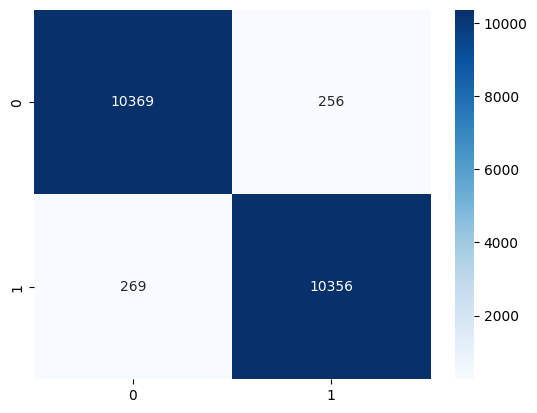

In [78]:
import seaborn as sns 

sns.heatmap(cm, cmap='Blues', fmt="g", annot=True)

In [ ]:
# Save the model
model.save(f"./sentimentLSTM_{round(accuracy,3)}.h5")